# **Figure ?.** Diffusion Coefficient
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created | 01/31/2022          |
| Updated | 08/05/2022          |

## $D$, $H_\mathrm{p}$ vs. $\Pi$
See Yang et al. (2009), § 4.1, for CC's derivation of the diffusion coefficient, $D$.

From Eq. 9 of Yang & Zhu (2021),
\begin{equation}
  H_\mathrm{p} \approx \sqrt{\frac{D_z}{\Omega_\mathrm{K}}\left(\tau_\mathrm{s} + \frac{1}{\tau_\mathrm{s}}\right)} = H_\mathrm{g}\sqrt{\frac{D_z}{c_\mathrm{s}H_\mathrm{g}}\left(\tau_\mathrm{s} + \frac{1}{\tau_\mathrm{s}}\right)},
\end{equation}
where $(\tau_\mathrm{s} + \tau_\mathrm{s}^{-1})/\Omega_\mathrm{K}$ is the sedimentation time-scale (Youdin & Lithwick 2007).

### $H_\mathrm{p}$ plot?
  - https://www.geeksforgeeks.org/matplotlib-pyplot-twinx-in-python/

,Case,Function,a,±𝜎ₐ,k,±𝜎ₖ
0,AB,𝐷_z = aΠᵏ,3.3e-02,±9.2e-04,1.8e+00,±1.2e-02
1,AB,𝐷_x = aΠᵏ,9.0e-02,±4.6e-03,2.0e+00,±2.2e-02
2,BA,𝐷_z = aΠᵏ,1.2e-01,±5.0e-02,5.8e-01,±1.4e-01
3,BA,𝐷_x = aΠᵏ,3.1e-01,±5.4e-02,1.2e+00,±7.2e-02


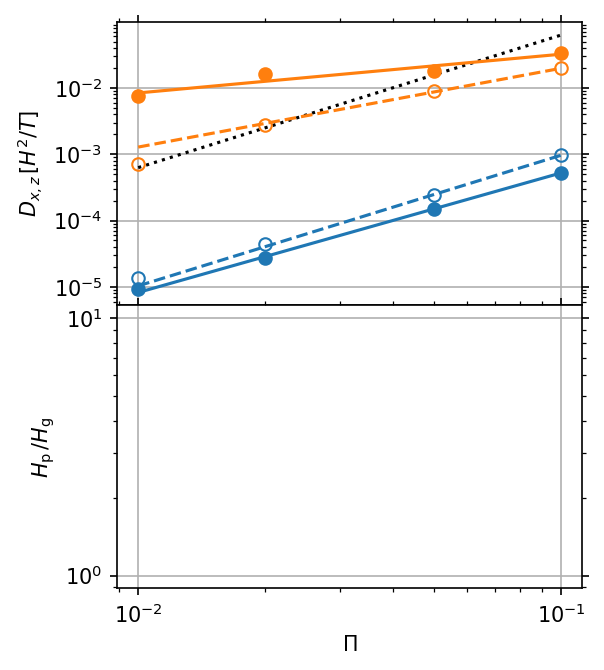

In [2]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

workdir = '../unstrat'
cases = [['AB', 'tab:blue'], ['BA', 'tab:orange']]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
dirs = [['z', 'dpy', 'full', 'solid'],
        ['x', 'dpx', 'none', 'dashed']]
dcoeffs = np.zeros((len(Pis), len(dirs)))
plaw = lambda Pi, a, k : a*Pi**k # Power-law model function
H_p = lambda D_pz, c_s, H_g, tau_s: math.sqrt(D_pz*(tau_s + 1/tau_s)/c_s/H_g)
group, modplaw, a, aerr, k, kerr = [], [], [], [], [], []
xfit = np.linspace(0.01, 0.1)
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(4, 5), dpi=150)

axs[0].plot(xfit, plaw(xfit, 2*np.pi, 2), ls=':', color='black',
            label=r'$D_\mathrm{max} = 2\pi\Pi^2$')

for case in cases:
    for i, dir in enumerate(dirs):
        for j, Pi in enumerate(Pis):
            path = f'{workdir}/{case[0]}/{Pi:.2f}/{res}'
            if case[0] == 'AB' and Pi == 0.01:
                dcoeff = np.load(f'{path}/output/dcoeff-61.npz')
            else: dcoeff = np.load(f'{path}/output/dcoeff-81.npz')
            dcoeffs[j, i] = dcoeff[dir[1]][0]

        # Best-fit and plot diffusion coefficients
        popt, pcov = curve_fit(plaw, Pis, dcoeffs[:, i])
        perr = np.sqrt(np.diag(pcov))
        D_pzs = plaw(xfit, *popt)
        form = f'𝐷_{dir[0]} = aΠᵏ'
        label = f'{case[0]}, $D_{dir[0]}$'
        axs[0].plot(Pis, dcoeffs[:, i], marker='o', ls='none',
                    color=case[1], fillstyle=dir[2])
        axs[0].plot(xfit, D_pzs, ls=dir[3], color=case[1], label=label)
        group.append(case[0]); modplaw.append(form)
        a.append(popt[0]); aerr.append(perr[0])
        k.append(popt[1]); kerr.append(perr[1])

        # Estimate and plot dust vertical scale heights
        athinput = athena_read.athinput(f'{path}/athinput.si')
        c_s = athinput['hydro']['iso_sound_speed']
        Omega = athinput['problem']['omega']
        tau_s= athinput['particles']['taus0']*Omega
        H_g = c_s/Omega
        # axs[1].plot(xfit, H_p(D_pzs, c_s, H_g, tau_s), color=case[1],
        #             label=f'{case[0]}, $H_\mathrm{{{P}}}$')

for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True)

axs[0].legend(loc='lower right')
axs[0].set(ylabel=r'$D_{x,z}\,[H^2/T]$', xscale='log',
           yscale='log',)# ylim=(5e-7, 2e-2))
axs[1].set(xlabel=r'$\Pi$', ylabel=r'$H_\mathrm{p}\,/H_\mathrm{g}$',
           xscale='log', yscale='log',)# xlim=(8e-3, 0.13))

fig.subplots_adjust(hspace=0)
# plt.savefig('figs/dcoeffs.pdf', bbox_inches='tight', pad_inches=0.01)-

df = pd.DataFrame({
    'Case'     : group,
    'Function' : modplaw,
    'a'        : a,
    '±𝜎ₐ'      : aerr,
    'k'        : k,
    '±𝜎ₖ'      : kerr,})
s = df.style.format({
    'a'   : '{:.1e}',
    '±𝜎ₐ' : '±{:.1e}',
    'k'   : '{:.1e}',
    '±𝜎ₖ' : '±{:.1e}',})
s.to_latex(buf='tabs/dcoeffs.txt')
s